# 1D Propagation of a Tsunami towards the Coast of Japan

Nihal Velagapudi, Brooke Sciandra, Emily Melvin

Video Walkthrough: https://www.youtube.com/watch?v=xuIgYwDnkWc

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
import pandas as pd
import xarray as xr
import geopy.distance
import matplotlib as mpl
import matplotlib.image as img

### Introduction

The theme of this project is the 1-dimensional propagation of a tsunami wave on the ocean created by an earthquake towards a coast. This topic is important because predicting the movement and intensity of tsunamis can help reduce deaths and injuries as well as associated destruction of land and developments. Tsunamis are shallow water waves, this means that the depth of the water is less than half of the wavelength.  Due to this, the depth impacts the height of the wave and the wave speed. As they approach land the waves slow down due to friction with the ocean floor, and the height of the wave increases. 

This project focuses on modeling the 2011 Tohoku earthquake and tsunami that impacted Japan. It was the most powerful earthquake recorded in Japan. The initial water displacement was reported at 24 m. The waves of the tsunami reached heights of up to 40.5 meters. The tsunami waves traveled up to 10 kilometers inland. It took approximately 30 minutes after the earthquake for the wave to reach shore. 

### Equations

## $$\frac{\partial^2 ζ}{\partial t^2} - gH\frac{\partial^2 ζ}{\partial x^2} = 0 $$

ζ refers to the sea level changes, g is the gravitational constant (9.81 m/s^2), and H is the water depth.

To determine wave speed (α), the following equations were used:

### $$α = \sqrt{gH} $$

### $$λ = α\frac{dt}{dx}$$

#### Boundary Conditions

An open boundary condition was used on the shore side of the domain.

A reflective boundary condition was used on the epicenter side of the domain.

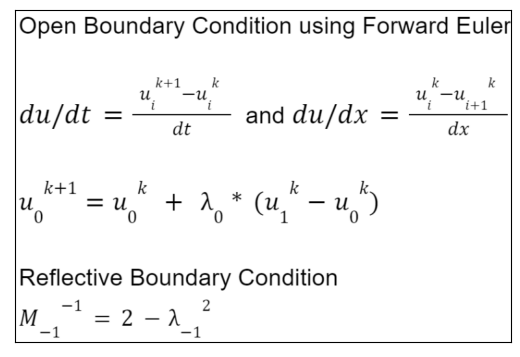

In [2]:
image=img.imread("boundary conditions.png")
fig=plt.imshow(image)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show()

### Numerical Methods

First, we created a simple model of the wave equation using the in-class demo code. 
We then adapted that code to our model of the Japan earthquake using the previously mentioned bathymetry data and relevant parameters. We used the centered difference scheme to solve the wave equation in our model. This is the method used for the wave equation because it has second derivatives, and centered difference is necessary to isolate the second derivatives.

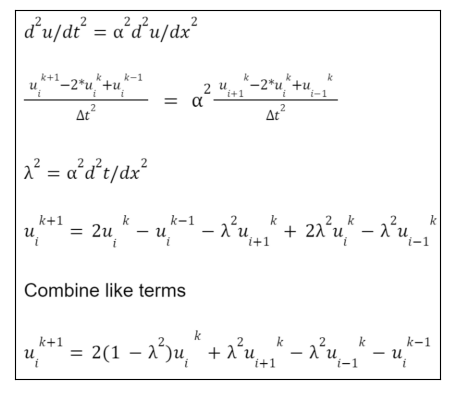

In [3]:
image=img.imread("centered diff math.png")
fig=plt.imshow(image)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show()

### Results

#### Simple Model

The parameters are modeled after a simplified shoreline. Halfway through the domain, the depth changed from 200 m to 50 m to represent the shift from the open ocean to the continental shelf.

In [4]:
L = 120000 #meters is epicenter
nx = 3360
nt = 10000
tf = 60*30  #sec

t = np.linspace(0,tf,nt)
x = np.linspace(0,L,nx)
dt = t[1]-t[0]
dx = x[1]-x[0]

gravity = 9.81 #m/s^2
depth1 = 50 #meters coastal depth
depth2 = 200 #meters open ocean depth
halfway = 0.5*L
alpha1 = np.sqrt(depth1 * gravity)
alpha2 = np.sqrt(depth2 * gravity)

#applying the equation for lambda
lam = np.zeros(nx)
lam[x<=halfway] = alpha1*dt/dx
lam[x>halfway] = alpha2*dt/dx

To demonstrate the impact of the earthquake the initial condition is an exponential reaching a maximum height of 24 m, the same displacement seen in the earthquake of interest. 

In [5]:
u = np.nan*np.ones([nx,nt])
u[:,0] = 24*np.flip(np.exp(-(x**2) / 2)) #initializing first two time steps with a maximum of 24 m
u[:,1] = 24*np.flip(np.exp(-(x**2) / 2))

The centered differencing method was used to create our matrix.

In [6]:
data = np.array([(lam**2)*np.ones(nx), 2*(1-lam**2)*np.ones(nx), (lam**2)*np.ones(nx)])
diags = np.array([-1, 0, 1])
M = spdiags(data, diags, nx, nx).toarray()

A reflective boundary condition is used at the epicenter and the open boundary condition is used at the shore.

In [7]:
#Reflective BC
M[-1,-1] = 2-lam[-1]**2 #epicenter

for k in np.arange(nt-2):
    u[:,k+2] = np.matmul(M,u[:,k+1]) - u[:,k]
    u[0,k+1] = u[0,k] + lam[0]*(u[1,k]-u[0,k]) #open BC at shore

Figure 1 is a plot of displacement of the tsunami wave against distance from the shore. The dotted line shows the halfway mark where the depth decreases.

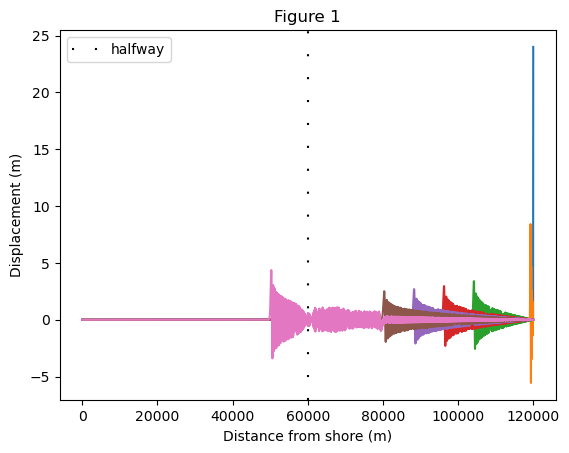

In [8]:
plt.plot(x, u[:,0])
plt.plot(x, u[:,100])
plt.plot(x, u[:,2000])
plt.plot(x, u[:,3000])
plt.plot(x, u[:,4000])
plt.plot(x, u[:,5000])
plt.plot(x, u[:,-1])
plt.axvline(x=halfway,linestyle=(0, (1, 10)),color='black',label="halfway")
plt.xlabel('Distance from shore (m)')
plt.ylabel('Displacement (m)')
plt.title("Figure 1")
plt.legend()
plt.show()

Figure 2 is a plot of time against displacement at a few different spaces.

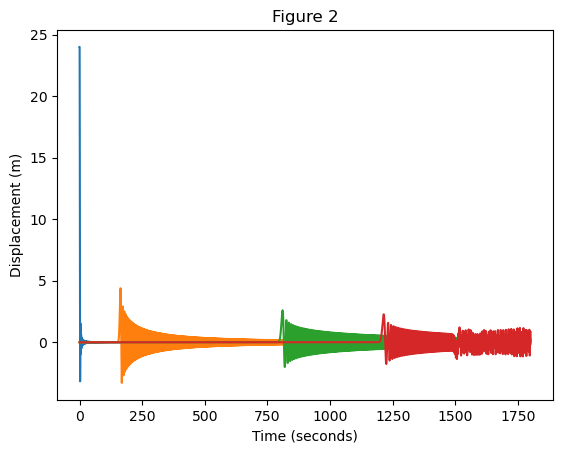

In [9]:
plt.plot(t, u[-1,:])
plt.plot(t, u[-200,:])
plt.plot(t, u[-1000,:])
plt.plot(t, u[-1500,:])
plt.xlabel('Time (seconds)')
plt.ylabel('Displacement (m)')
plt.title("Figure 2")
plt.show()

#### 2011 Tohoku Model

Next, we modeled the Tohoko earthquake using bathymetry data.

In [10]:
ds=xr.open_dataset('gebco_2023_n38.3_s38.2_w140.0_e142.369.nc')
depth=ds['elevation'][1,:]
depth=depth[depth.values<0]
length=len(depth)

In [11]:
from scipy import interpolate
f = interpolate.interp1d(depth.lon, depth)
lon_new = np.linspace(depth.lon[0], depth.lon[-1], len(depth.lon)*10)
depth_new = f(lon_new)

Due to the coarseness of this data set, we used sci py.interpolate to artificially increase the resolution of the depth array tenfold to a final grid spacing of 37 m.

In [12]:
coords_1 = (depth.lat, depth.lon[0])
coords_2 = (depth.lat, depth.lon[-1])
total_dist = geopy.distance.geodesic(coords_1, coords_2).m
dx = total_dist/len(depth_new)
print(dx, 'm')

36.710997414936045 m


In [13]:
nx = len(depth_new)
nt = 10000 

tf = 60*30

x = lon_new
x = np.array(x)
t = np.linspace(0,tf,nt)

dt = t[1]-t[0]

gravity = 9.81 #m/s
g = gravity

alpha = np.sqrt(abs(depth_new*g))
lam = alpha*dt/dx

x1 = np.arange(0,total_dist,dx)

In [14]:
lam[-1] #lam^2 <=1

0.4890724888764544

Lambda squared must be less than or equal to 1 to ensure stability.

In [15]:
u = np.nan*np.ones([nx,nt])

u[:,0]=24*np.flip(np.exp(-(x1**2)/2)) #initializing first two time steps bc we have k-1
u[:,1]=24*np.flip(np.exp(-(x1**2)/2))

data = np.array([(lam**2)*np.ones(nx), 2*(1-lam**2)*np.ones(nx), (lam**2)*np.ones(nx)])
diags = np.array([-1, 0, 1])
M = spdiags(data, diags, nx, nx).toarray()

#Reflective BC at epicenter
M[-1,-1] = 2-lam[-1]**2

for k in np.arange(1,nt-2):
    u[:,k+1] = np.matmul(M,u[:,k]) - u[:,k-1]
    u[0,k+1]=u[0,k]+lam[0]*(u[1,k]-u[0,k]) #open BC at shore

Figure 3 shows the displacement of the tsunami wave against the distance from shore. 

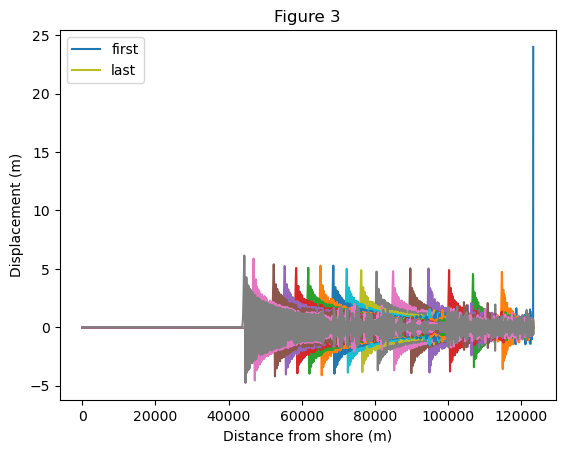

In [16]:
plt.plot(x1, u[:,0],label="first")
plt.plot(x1, u[:,500])
plt.plot(x1, u[:,1000])
plt.plot(x1, u[:,1500])
plt.plot(x1, u[:,2000])
plt.plot(x1, u[:,2500])
plt.plot(x1, u[:,3000])
plt.plot(x1, u[:,3500])
plt.plot(x1, u[:,4000])
plt.plot(x1, u[:,4500])
plt.plot(x1, u[:,5000])
plt.plot(x1, u[:,5500])
plt.plot(x1, u[:,6000])
plt.plot(x1, u[:,6500])
plt.plot(x1, u[:,7000])
plt.plot(x1, u[:,7500])
plt.plot(x1, u[:,8500])
plt.plot(x1, u[:,9000])
plt.plot(x1, u[:,-1],label='last')
plt.xlabel('Distance from shore (m)')
plt.ylabel('Displacement (m)')
plt.legend()
plt.title("Figure 3")
plt.show()

#### Changing Wavespeed (α)

Here, we keep everything the same as the 2011 Tohoku Model, but double the wavespeed (alpha) before calculating lambda.

In [17]:
nx = len(depth_new)
nt = 10000

tf = 60*30

x = lon_new
x = np.array(x)
t = np.linspace(0,tf,nt)

dt = t[1]-t[0]

gravity = 9.81 #m/s
g = gravity

alpha = np.sqrt(abs(depth_new*g))
alpha=alpha*2   #wavespeed doubled
lam = alpha*dt/dx

x1 = np.arange(0,total_dist,dx)

In [18]:
lam[-1] #lam^2 <=1

0.9781449777529088

In [19]:
u = np.nan*np.ones([nx,nt])

u[:,0]=24*np.flip(np.exp(-(x1**2)/2)) #initializing first two time steps bc we have k-1
u[:,1]=24*np.flip(np.exp(-(x1**2)/2))

data = np.array([(lam**2)*np.ones(nx), 2*(1-lam**2)*np.ones(nx), (lam**2)*np.ones(nx)])
diags = np.array([-1, 0, 1])
M = spdiags(data, diags, nx, nx).toarray()

#Reflective BC at shore
M[-1,-1] = 2-lam[-1]**2

for k in np.arange(1,nt-2):
    u[:,k+1] = np.matmul(M,u[:,k]) - u[:,k-1]
    u[0,k+1]=u[0,k]+lam[0]*(u[1,k]-u[0,k]) #open BC at epicenter

Figure 4 shows the displacement of the tsunami wave against the distance from shore with the doubled wavespeed.

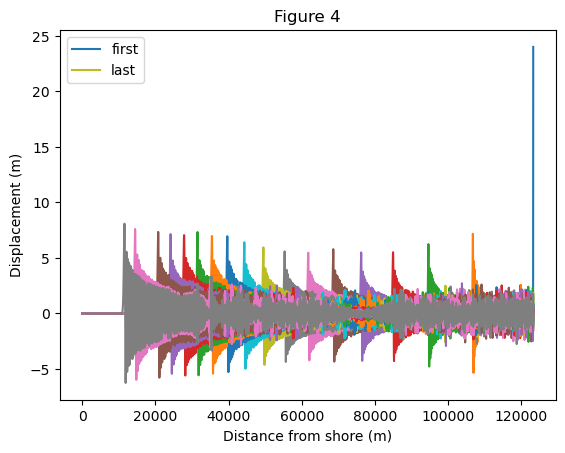

In [20]:
plt.plot(x1, u[:,0],label="first")
plt.plot(x1, u[:,500])
plt.plot(x1, u[:,1000])
plt.plot(x1, u[:,1500])
plt.plot(x1, u[:,2000])
plt.plot(x1, u[:,2500])
plt.plot(x1, u[:,3000])
plt.plot(x1, u[:,3500])
plt.plot(x1, u[:,4000])
plt.plot(x1, u[:,4500])
plt.plot(x1, u[:,5000])
plt.plot(x1, u[:,5500])
plt.plot(x1, u[:,6000])
plt.plot(x1, u[:,6500])
plt.plot(x1, u[:,7000])
plt.plot(x1, u[:,7500])
plt.plot(x1, u[:,8500])
plt.plot(x1, u[:,9000])
plt.plot(x1, u[:,-1],label='last')
plt.xlabel('Distance from shore (m)')
plt.ylabel('Displacement (m)')
plt.title("Figure 4")
plt.legend()
plt.show()

### References

Kowalik, Z. (2012). Introduction to numerical modeling of tsunami waves. Institute of Marine Science University of Alaska, Fairbank.

On This Day: 2011 Tohoku Earthquake and Tsunami. (2021, March 11). Retrieved December 4, 2023, from National Centers for Environmental Information (NCEI) website: https://www.ncei.noaa.gov/news/day-2011-japan-earthquake-and-tsunami#:~:text=The%20March%2011%2C%202011%20earthquake,was%20impacted%20by%20the%20tsunami.

Reuters. (2011, April 7). Japan seabed shifted 24 meters after March quake. Retrieved December 4, 2023, from Reuters website: https://www.reuters.com/article/us-japan-seabed-idUSTRE73607620110407/

Sugawara, D. (2021). Numerical modeling of tsunami: Advances and future challenges after the 2011 Tohoku earthquake and tsunami. Earth-Science Reviews, 214, 103498.

Webb, P. (2023). 10.4 Tsunamis. Retrieved December 4, 2023, from Pressbooks.pub website: https://rwu.pressbooks.pub/webboceanography/chapter/10-4-tsunamis/